### 필요 라이브러리 설치 및 CLIP 모델 불러오기, 모듈 import

In [ ]:
!pip install torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import torch
import clip
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 946.6 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jj80201x
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jj80201x
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=bbfe24856821fec139d89261623fb3cc93ac7b68af1ab4585e86bb4097785008
  Stored in directory: /tmp/pip-ephem-wheel-cache-y1idp52t/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


### CLIP 모델 로드

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 120MiB/s]


### cifar10 dataset 다운로드

In [ ]:
cifar10 = torchvision.datasets.CIFAR10(root="./data", download=True, train=False)

100%|██████████| 170498071/170498071 [00:18<00:00, 9194568.74it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


### 클래스 정의 및 분류 함수 설정

In [ ]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
def zero_shot_classify(image, class_names):
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(len(class_names))

    return [(class_names[idx], val.item() * 100) for idx, val in zip(indices, values)]

### 테스트 및 시각화

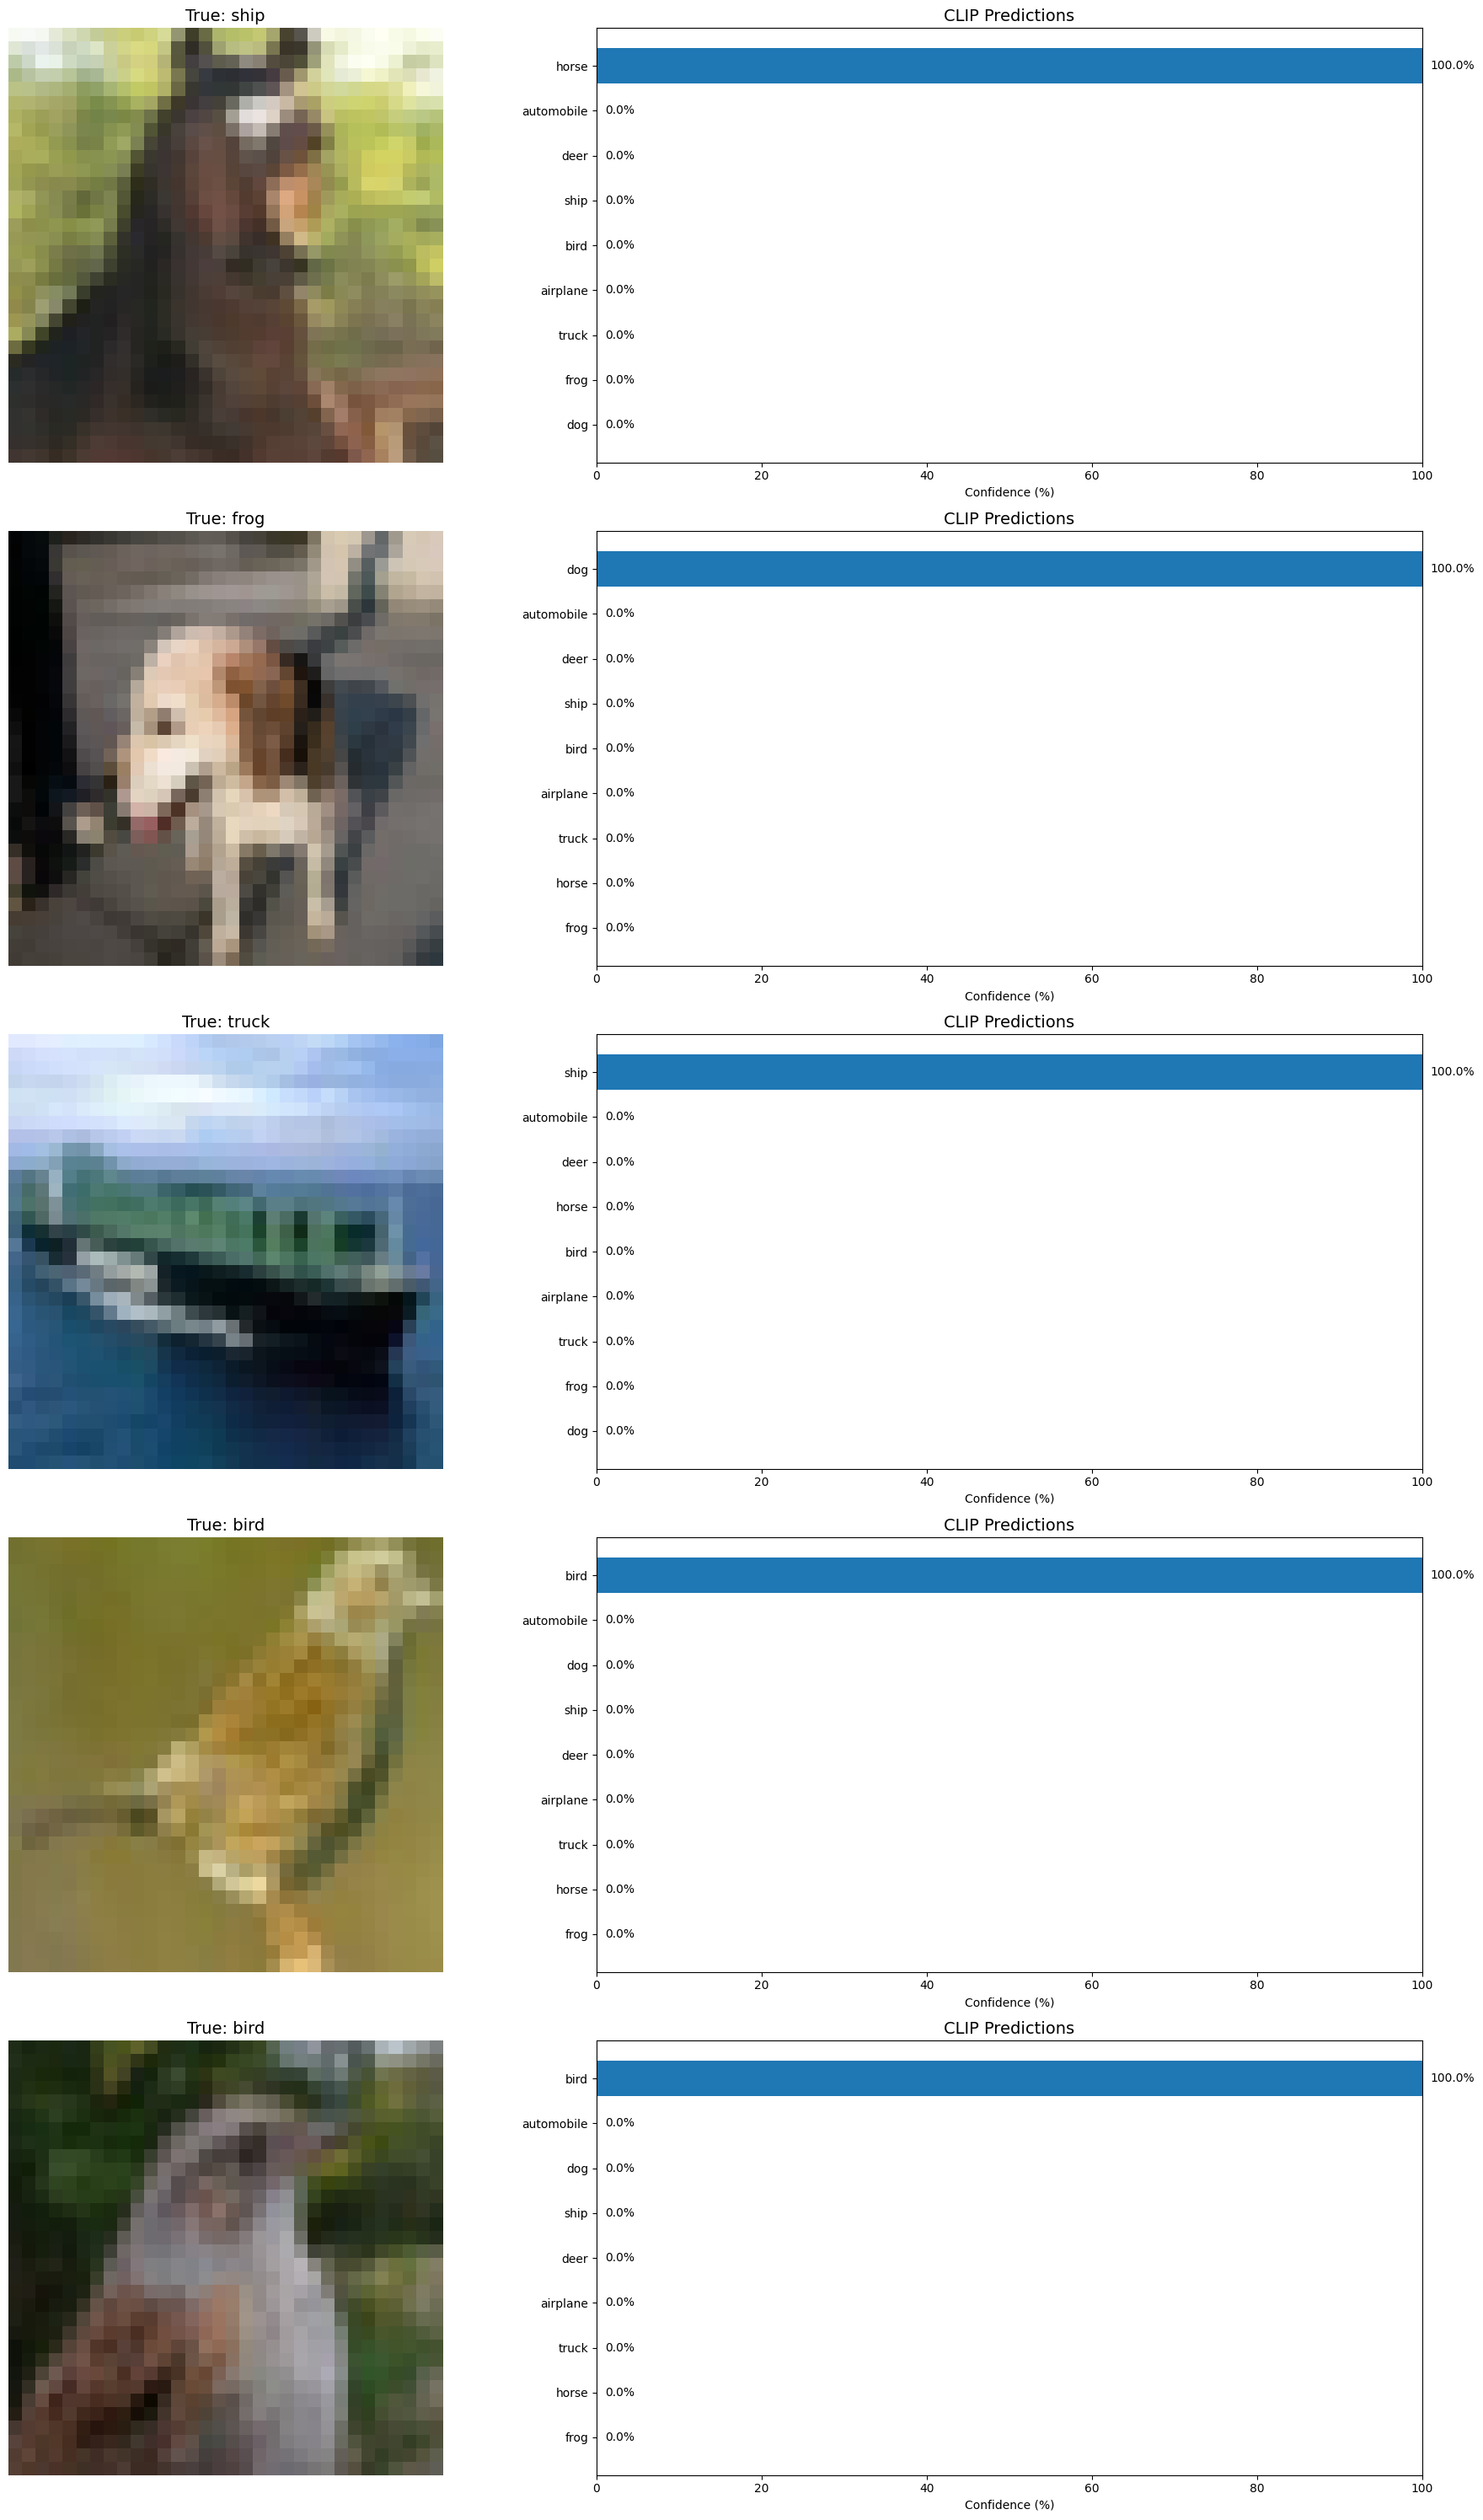

In [ ]:
def test_and_visualize(num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(20, 6*num_samples))

    for i in range(num_samples):
        idx = np.random.randint(0, len(cifar10))
        image, label = cifar10[idx]

        results = zero_shot_classify(image, cifar10_classes)

        axs[i, 0].imshow(image)
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f"True: {cifar10_classes[label]}", fontsize=14)

        classes, scores = zip(*results)
        y_pos = range(len(classes))
        axs[i, 1].barh(y_pos, scores, align='center')
        axs[i, 1].set_yticks(y_pos)
        axs[i, 1].set_yticklabels(classes)
        axs[i, 1].invert_yaxis()  # labels read top-to-bottom
        axs[i, 1].set_xlabel('Confidence (%)')
        axs[i, 1].set_xlim(0, 100)
        axs[i, 1].set_title("CLIP Predictions", fontsize=14)

        # Add value labels to the bars
        for j, v in enumerate(scores):
            axs[i, 1].text(v + 1, j, f'{v:.1f}%', va='center')

    plt.tight_layout()
    plt.show()

test_and_visualize()

### 성능 evaluation

In [ ]:
def evaluate_performance(num_samples=1000):
    correct = 0
    top3_correct = 0

    for i in range(num_samples):
        image, label = cifar10[i]
        results = zero_shot_classify(image, cifar10_classes)

        if cifar10_classes[label] == results[0][0]:
            correct += 1

        if cifar10_classes[label] in [r[0] for r in results]:
            top3_correct += 1

    accuracy = correct / num_samples * 100
    top3_accuracy = top3_correct / num_samples * 100

    print(f"Top-1 Accuracy: {accuracy:.2f}%")
    print(f"Top-3 Accuracy: {top3_accuracy:.2f}%")

evaluate_performance()

Top-1 Accuracy: 80.20%
Top-3 Accuracy: 84.50%


### Image Encoder 마지막 Layer Fine Tuning 실습

In [ ]:
import torch
import clip
from torch import nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

# CLIP 모델 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 모델을 float32로 변환
model = model.float()

# 새로운 분류기 정의
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model):
        super(CLIPClassifier, self).__init__()
        self.clip_model = clip_model
        self.classifier = nn.Linear(512, 10)  # CIFAR10은 10개 클래스

    def forward(self, image):
        features = self.clip_model.encode_image(image)
        return self.classifier(features)

# 모델 생성 및 장치로 이동
classifier = CLIPClassifier(model).to(device)

# CLIP의 이미지 인코더 파라미터 고정
for param in classifier.clip_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어만 fine-tuning
for param in classifier.clip_model.visual.transformer.resblocks[-1].parameters():
    param.requires_grad = True

# 옵티마이저 설정
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=1e-3)

# 데이터 로드
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

# 학습 루프
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training finished!")

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/5], Loss: 0.4585
Epoch [2/5], Loss: 0.2465
Epoch [3/5], Loss: 0.5199
Epoch [4/5], Loss: 0.1326
Epoch [5/5], Loss: 0.0272
Training finished!


In [ ]:
# CIFAR10 테스트 데이터셋 로드
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# 모델을 평가 모드로 전환 (Dropout, BatchNorm 등이 테스트 모드로 전환됨)
classifier.eval()

# 정확도 평가
correct = 0
total = 0

with torch.no_grad():  # 테스트 시에는 그래디언트를 계산하지 않음
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # 예측 수행
        outputs = classifier(images)

        # 예측된 라벨은 가장 높은 값의 인덱스
        _, predicted = torch.max(outputs.data, 1)

        # 총 라벨 수와 맞춘 개수 계산
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 정확도 출력
accuracy = 100 * correct / total
print(f'Test Accuracy of the model on the 10,000 test images: {accuracy:.2f}%')


Files already downloaded and verified
Test Accuracy of the model on the 10,000 test images: 92.34%
